In [25]:
#Set-up
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import warnings
from IPython.display import clear_output
import nibabel as nib

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.utils.data as utils
import time
import copy

In [26]:
# x = torch.load("../../../data/data.pt")
# y = torch.load("../../../data/labels_1.pt")
# n = x.shape[0]
# print(x.shape,y.shape)

In [27]:
fcp_x = torch.load("../../../data/fcp_data.pt")
fcp_y = torch.load("../../../data/fcp_labels_1.pt")
print(fcp_x.shape,fcp_y.shape)
n = fcp_x.shape[0]

torch.Size([1034, 3, 224, 224]) torch.Size([1034])


In [28]:
fcp_x_normalized = torch.Tensor(fcp_x.shape)
for i in range(n):
    fcp_x_normalized[i] = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]).__call__(fcp_x[i,:,:])

In [29]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [30]:
dataset = utils.TensorDataset(fcp_x_normalized, fcp_y)

In [37]:
# dataloaders = {i: torch.utils.data.DataLoader(dataset, batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for i in ['train', 'val']}
train_indices = [i for i in range(n) if i % 2 == 0]
val_indices = [i for i in range(n) if i % 2 == 1]
test_indices = [i for i in range(n) if i % 3 == 2]
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset, batch_size=4,
                                             shuffle=False,sampler=utils.sampler.SubsetRandomSampler(train_indices),num_workers=4)
dataloaders['val'] = torch.utils.data.DataLoader(dataset, batch_size=4,
                                             shuffle=False,sampler=utils.sampler.SubsetRandomSampler(val_indices),num_workers=4)

In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss =[]
    val_loss =[]
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / n
            epoch_acc = running_corrects.double() / n
            
            
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss.append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    plt.subplot(2, 1, 1)
    plt.plot(train_loss, '-o')
    plt.plot(val_loss, '-o')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.subplot(2, 1, 2)
    plt.plot(train_acc_history, '-o')
    plt.plot(val_acc_history, '-o')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [50]:
model_ft = models.resnet101(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 13)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Epoch 0/19
----------
train Loss: 0.9308 Acc: 0.2321
val Loss: 0.9537 Acc: 0.2505

Epoch 1/19
----------
train Loss: 0.8919 Acc: 0.2456
val Loss: 0.8578 Acc: 0.2534

Epoch 2/19
----------
train Loss: 0.8598 Acc: 0.2466
val Loss: 0.8595 Acc: 0.2534

Epoch 3/19
----------
train Loss: 0.8458 Acc: 0.2427
val Loss: 0.8523 Acc: 0.2534

Epoch 4/19
----------
train Loss: 0.8252 Acc: 0.2505
val Loss: 0.8433 Acc: 0.2534

Epoch 5/19
----------
train Loss: 0.8106 Acc: 0.2505
val Loss: 0.8575 Acc: 0.2534

Epoch 6/19
----------
train Loss: 0.8073 Acc: 0.2505
val Loss: 0.8586 Acc: 0.2534

Epoch 7/19
----------
train Loss: 0.8097 Acc: 0.2505
val Loss: 0.8776 Acc: 0.2534

Epoch 8/19
----------
train Loss: 0.7890 Acc: 0.2505
val Loss: 0.8873 Acc: 0.2534

Epoch 9/19
----------
train Loss: 0.7830 Acc: 0.2505
val Loss: 0.8850 Acc: 0.2534

Epoch 10/19
----------
train Loss: 0.7826 Acc: 0.2505
val Loss: 0.8564 Acc: 0.2534

Epoch 11/19
----------
train Loss: 0.7818 Acc: 0.2505
val Loss: 0.8570 Acc: 0.2534

Ep

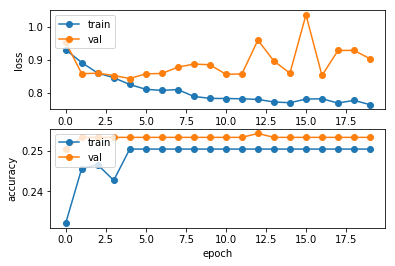

In [51]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

In [ ]:
# torch.save(model_ft.state_dict(), "best_classification_model.pth")